# 2. Feature Selection

## 2.1 Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = pd.read_csv("/data/data.csv")
data_dropped_outlier = pd.read_csv("/data/data_dropped_outlier.csv")
data_tf_outlier = pd.read_csv("/data/data_tf_outlier.csv")
data_enc = pd.read_csv("/data/data_enc.csv")
data_drop_outlier_enc = pd.read_csv("/data/data_drop_outlier_enc.csv")
data_tf_outlier_enc = pd.read_csv("/data/data_tf_outlier_enc.csv")

In [ ]:
data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,...,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,CPI_class
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,...,0,0,0,0,1,0,0,0,3,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,...,1,0,0,0,0,0,0,0,3,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,...,0,0,0,0,0,0,0,0,3,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,...,0,0,0,0,0,0,0,0,3,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010,...,0,0,0,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012,...,0,0,0,0,0,0,0,0,3,1
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,5,10,2012,...,0,0,0,0,0,0,0,0,3,1
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,12,10,2012,...,0,0,0,0,0,0,0,0,3,1
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012,...,0,0,0,0,0,0,0,0,3,1


## 2.2 Feature Importance

In [ ]:
target = "Weekly_Sales"
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]
features = [i for i in data_enc.columns if i not in [target]] #store all features name
print("Data target adalah: {}".format(target))
print("Data fitur berjumlah {} dan terdiri dari : {}".format(len(features), features))

Data target adalah: Weekly_Sales
Data fitur berjumlah 158 dan terdiri dari : ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'Before_Super_Bowl', 'Before_Labor_Day', 'Before_Thanksgiving', 'Before_Christmas', 'Unemployment_class', 'CPI_class', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16

The number of features in the dataset becomes 151 after going through the dummy encoding process. These features are too much to process and not all of them are relevant so we need to do a feature selection first.

One way to look at *feature improtance* is to use the coefficients generated by the regressor (source: [feature importance for linear models -AnalyticsVidhya](https://medium.com/analytics-vidhya/feature-importance-explained-bfc8d874bcf#:~:text=Source-,What%20is%20Feature%20importance%20%3F,both%20classification%20and%20regression%20problem)). Therefore, we will use [RFE (Recursive Feature Elimination)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), one of the most popular *feature selection* methods. By using *estimator* which can produce coefficient values (which in this case we use coefficients from the model), RFE will eliminate features recursively based on *feature importance* of each feature.

In [ ]:
# Set features and target values to seperated variables

# Data with outliers
y = data_enc[target]
X = data_enc[features] 

# Data with outliers dropped
y_2 = data_drop_outlier_enc[target]
X_2 = data_drop_outlier_enc[features]

# Data with outliers floored and capped
y_3 = data_tf_outlier_enc[target]
X_3 = data_tf_outlier_enc[features]

In [ ]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.4, random_state = 42)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.4, random_state = 42)

In [ ]:
# Dataset with outliers
print("Original dataset :", X.shape, y.shape)
print("Training dataset :", X_train.shape, y_train.shape)
print("Testing dataset  :", X_test.shape,"", y_test.shape)
print("")

#Dataset with outliers removed
print("Original dataset 2 :", X_2.shape, y_2.shape)
print("Training dataset 2 :", X_train_2.shape, y_train_2.shape)
print("Testing dataset  2 :", X_test_2.shape,"", y_test_2.shape)
print("")

#Dataset with outliers floored and capped
print("Original dataset 3 :", X_3.shape, y_3.shape)
print("Training dataset 3 :", X_train_3.shape, y_train_3.shape)
print("Testing dataset  3 :", X_test_3.shape,"", y_test_3.shape)

Original dataset : (6435, 158) (6435,)
Training dataset : (3861, 158) (3861,)
Testing dataset  : (2574, 158)  (2574,)

Original dataset 2 : (6057, 158) (6057,)
Training dataset 2 : (3634, 158) (3634,)
Testing dataset  2 : (2423, 158)  (2423,)

Original dataset 3 : (6435, 158) (6435,)
Training dataset 3 : (3861, 158) (3861,)
Testing dataset  3 : (2574, 158)  (2574,)


## 2.3 Feature Ranking using RFE (Recursive Feature Elimination)

To use RFE, we must fill in the parameter n_features_to_select with the number of features we want to select. The problem is, we don't know how many features produce the best *performance*. Therefore, we will loop with all possible number of features, then we will choose the number of features that have the best *performance*.

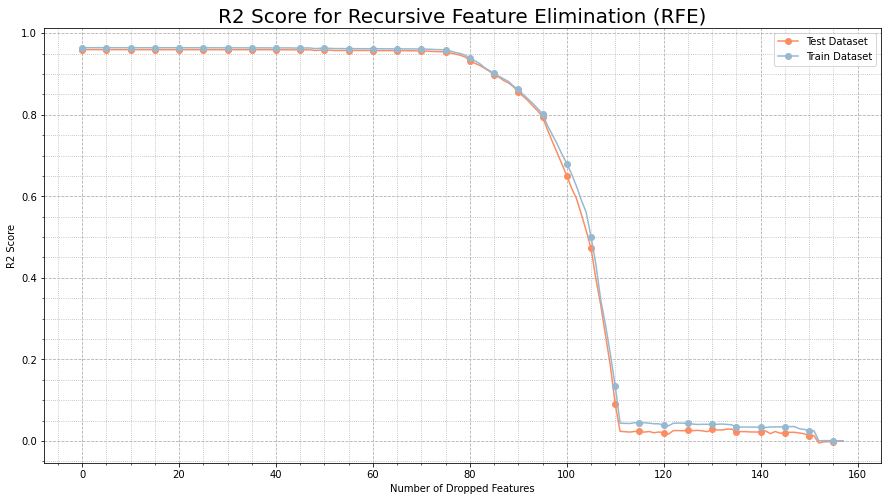

In [ ]:
# Feature Selection with RFE

rfe_train = []; rfe_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform RFE
    rfe           = RFE(estimator = LinearRegression(), n_features_to_select = X_train.shape[1]-i)
    rfe           = rfe.fit(X_train, y_train)
    # Perform regression (Linear Regression here since it's the simplest one) with the selected features
    regressor     = LinearRegression()
    regressor.fit(X_train.loc[:,rfe.support_], y_train)
    # Predict the target values for the both training and testing sets
    y_pred_train  = regressor.predict(X_train.loc[:,rfe.support_])
    y_pred_test   = regressor.predict(X_test.loc[:,rfe.support_])
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    rfe_train.append(r2_train)
    rfe_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(rfe_test, color = palette[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(rfe_train, color = palette[5], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped Features")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Recursive Feature Elimination (RFE)", fontsize = 20)
plt.legend()
plt.show()

Based on the RFE graph above, the R2 Score starts to drop drastically when the number of features dropped is >75, which means there are around 76 (151-75) features that have a higher *importance* than other features.

## 2.4 Feature Decomposition using PCA (Principal Component Analysis)

Unlike RFE which will eliminate the feature with the lowest coefficient value, PCA will combine n-component features according to the *variance* value of each feature, so that each feature still has a role in the modeling according to its respective contribution.

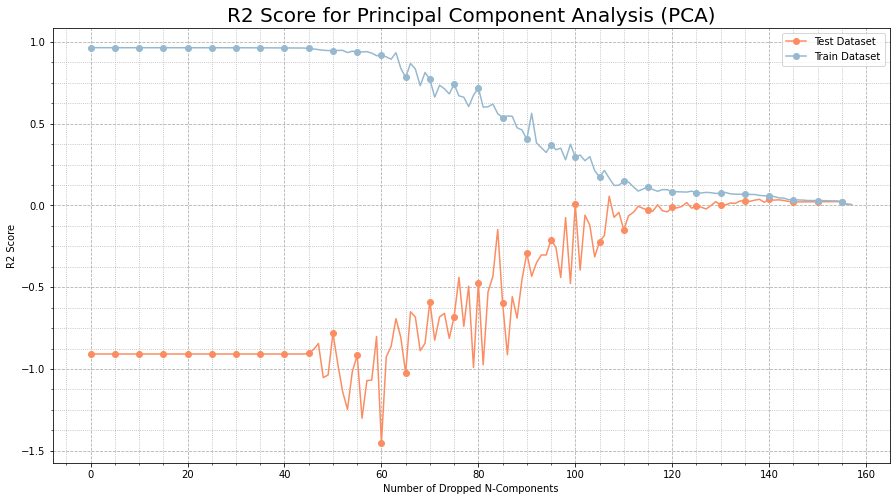

In [ ]:
# Feature Selection with PCA

pca_train = []; pca_test = []
# Looping through all the features
for i in range (len(features)):
    # Perform PCA
    pca           = PCA(n_components = X_train.shape[1]-i)
    X_train_pca   = pca.fit_transform(X_train)
    X_test_pca    = pca.fit_transform(X_test)
    # Predict the target values for the both training and testing sets
    regressor     = LinearRegression()
    regressor.fit(X_train_pca, y_train)
    y_pred_train  = regressor.predict(X_train_pca)
    y_pred_test   = regressor.predict(X_test_pca)
    # Calculate the r2 score
    r2_train      = r2_score(y_train, y_pred_train)
    r2_test       = r2_score(y_test, y_pred_test)
    # Store the evaluation results
    pca_train.append(r2_train)
    pca_test.append(r2_test)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(pca_test, color = palette[0], label = "Test Dataset", marker = 'o', markevery = 5)
plt.plot(pca_train, color = palette[5], label = "Train Dataset", marker = 'o', markevery = 5)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# Turn grid on for both major and minor ticks.
ax.grid(which = "major", linestyle = "--")
ax.grid(which = "minor", linestyle = ":")
plt.xlabel("Number of Dropped N-Components")
plt.ylabel("R2 Score")
plt.title ("R2 Score for Principal Component Analysis (PCA)", fontsize = 20)
plt.legend()
plt.show()

It turns out that PCA has a *performance* that tends to be unstable compared to RFE because the R2 Score on the testing dataset fluctuates drastically and irregularly along with the increasing number of N-Components that are dropped so it seems safer to use RFE.

In [ ]:
rfe_final   = RFE(estimator = LinearRegression(), n_features_to_select = X_train.shape[1]-75) # Train with choosen number of features
rfe_final   = rfe_final.fit(X_train, y_train)
rfe_result  = pd.DataFrame(data = rfe_final.feature_names_in_, columns = ["Features"]) # Feature names
rfe_result["Selected"] = rfe_final.support_ # RFE selected value of each feature (True/False)
rfe_result["Ranking"]  = rfe_final.ranking_ # RFE ranking of each feature

pd.set_option("display.max_rows", 500) # Show all rows
rfe_result.sort_values(by = "Ranking", ignore_index = True) # Sort feature order by ranking

,Features,Selected,Ranking
0,Holiday_Flag,True,1
1,Month_12,True,1
2,Month_11,True,1
3,Month_10,True,1
4,Month_9,True,1
5,Month_8,True,1
6,Month_7,True,1
7,Month_6,True,1
8,Month_5,True,1
9,Month_4,True,1


Based on the results of the *feature ranking* above, the features that have a very low *rank* are the "Temperature", "Day", "CPI", "Fuel Price", "Unemployment" features, and some "WeekOfYear" features. However, it doesn't make sense to just remove some features from the overall categorical feature, specifically the "WeekOfYear" feature (such as removing "WeekOfYear_19" and "WeekOfYear_10" but not the others) because it makes the distribution of features uneven and still there are several WeekOfYear features with high *ranking*. Therefore, we will select only numeric features and categorical features whose overall encoded features have a low *rank*.

In [ ]:
cols_to_drop = ["Temperature", "CPI", "Fuel_Price", "Unemployment", "Day_1", "Day_2", "Day_3", "Day_4", "Day_5", 
                "Day_6", "Day_7", "Day_8", "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14", "Day_15", 
                "Day_16", "Day_17", "Day_18", "Day_19", "Day_20", "Day_21", "Day_22", "Day_23", "Day_24", "Day_25",
                "Day_26", "Day_27", "Day_28", "Day_29", "Day_30", "Day_31"]

# Drop selected column (with lowest importance feature)
data_enc = data_enc.drop(cols_to_drop, axis = 1)
data_drop_outlier_enc = data_drop_outlier_enc.drop(cols_to_drop, axis = 1)
data_tf_outlier_enc = data_tf_outlier_enc.drop(cols_to_drop, axis = 1)
new_features     = [i for i in data_enc.columns if i not in [target]] #store all features name

In [ ]:
# Set features and target values to seperated variables

# Data with outliers
y = data_enc[target]
X = data_enc[new_features]

# Data with outliers dropped
y_2 = data_drop_outlier_enc[target]
X_2 = data_drop_outlier_enc[new_features]

# Data with outliers floored and capped
y_3 = data_tf_outlier_enc[target]
X_3 = data_tf_outlier_enc[new_features]

## 2.5 Exporting Data

In [ ]:
X.to_csv("/data/X.csv", index=False)
y.to_csv("/data/y.csv", index=False)
X_2.to_csv("/data/X_2.csv", index=False)
y_2.to_csv("/data/y_2.csv", index=False)
X_3.to_csv("/data/X_3.csv", index=False)
y_3.to_csv("/data/y_3.csv", index=False)